This is the all-in-one draft notebook for the cloud eng final project. 

### Env

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load Data

In [2]:
# TripAdvisor hotel review dataset
url = r'https://raw.githubusercontent.com/wenchengking/Cloud_Engineering_DS/main/data/raw/tripadvisor_hotel_reviews.csv'
df = pd.read_csv(url, sep=',')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


### Data Cleaning and Processing

1. bundle ratings to satisfied (3/4/5) vs. unsatisfied (1/2)  
2. transform the texts using TF-IDF

In [3]:
# convert rating to 0/1
df['Rating'] = df['Rating'].apply(lambda x: 1 if x >= 3 else 0)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,1
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,1
3,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",1


In [4]:
# downsampling to balance the dataset
df = df.sample(frac=1)
df = pd.concat([df[df['Rating'] == 1][:1000], df[df['Rating'] == 0][:1000]])

In [5]:
df.Rating.value_counts()

Rating
1    1000
0    1000
Name: count, dtype: int64

In [6]:
# train/test split
X, y = df['Review'], df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# TF-IDF
print("TFIDF Vectorizer……")
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

TFIDF Vectorizer……


In [8]:
type(tf_x_train)

scipy.sparse.csr.csr_matrix

### Model Building and Training

In [9]:

print("Logistics Regression ……")

from sklearn.model_selection import GridSearchCV

param_grid = { 
    'C': [0.2,0.4,0.8,1.0,1.2,1.6],
    'penalty': ['l1', 'l2']}

clf = LogisticRegression()
CV_rfc = GridSearchCV(estimator=[clf], param_grid=[param_grid], cv= 5)

CV_rfc.fit(tf_x_train, y_train)
print('Best Params:', CV_rfc.best_params_)
clf_best=LogisticRegression(**CV_rfc.best_params_) # based on best_params_
clf_best.fit(tf_x_train, y_train)


Logistics Regression ……


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _che

Best Params: {'C': 1.6, 'penalty': 'l2'}


LogisticRegression(C=1.6)

Text(91.68, 0.5, 'predicted label')

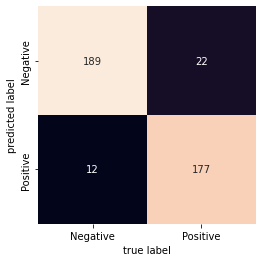

In [10]:
mat = confusion_matrix(y_test, clf_best.predict(tf_x_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [11]:
#retrain the model with all the data and savee the model to pickle file
import pickle
clf_best.fit(tf_x_train, y_train)
pickle.dump(clf_best, open('model.pkl','wb'))
pickle.dump(vectorizer, open('vectorizer.pkl','wb'))